1. Describe the target (1–2 sentences): what you’re scraping and why it’s suitable.
>I'm scraping https://books.toscrape.com/, because my profesor gave us this example as a good source to scrape from. It's an educational sandbox, so I know it's suitable.

2. Inspect with DevTools

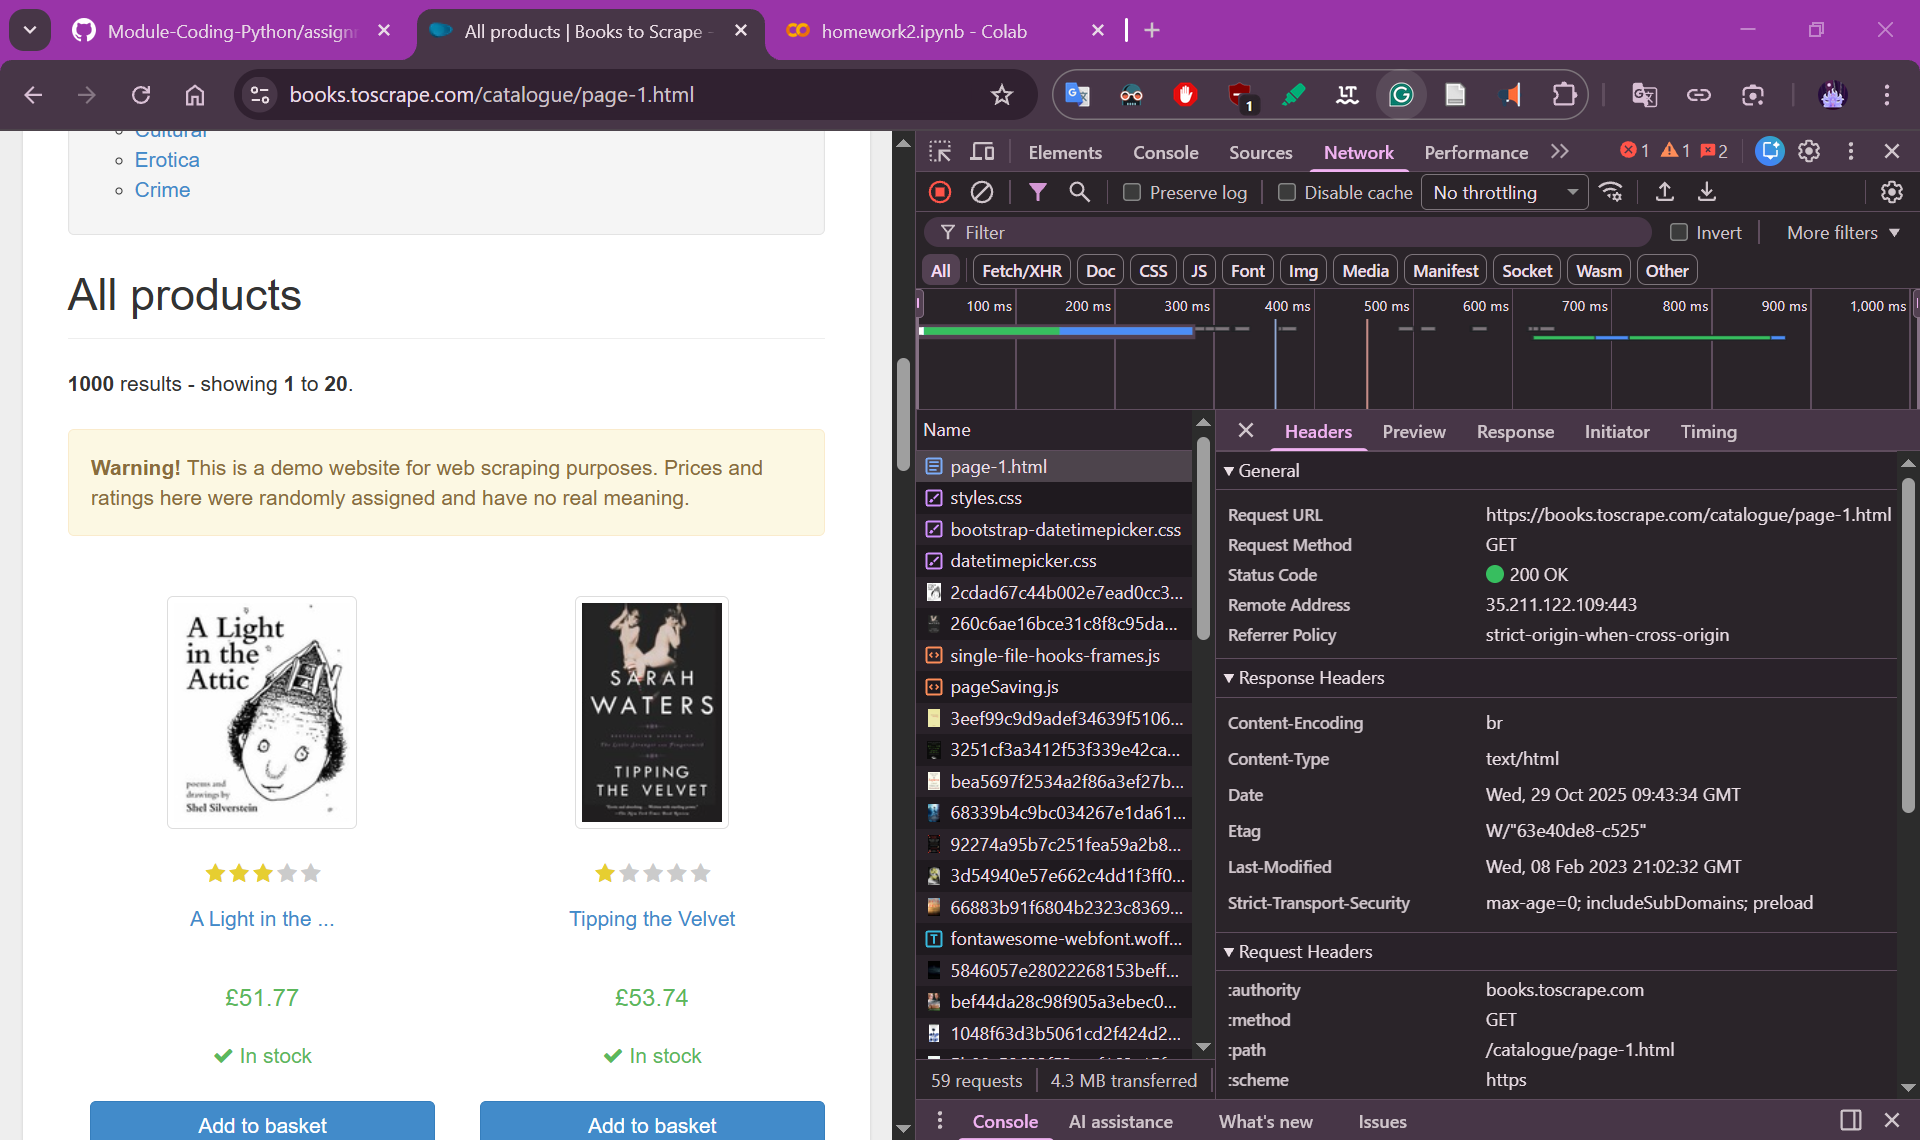

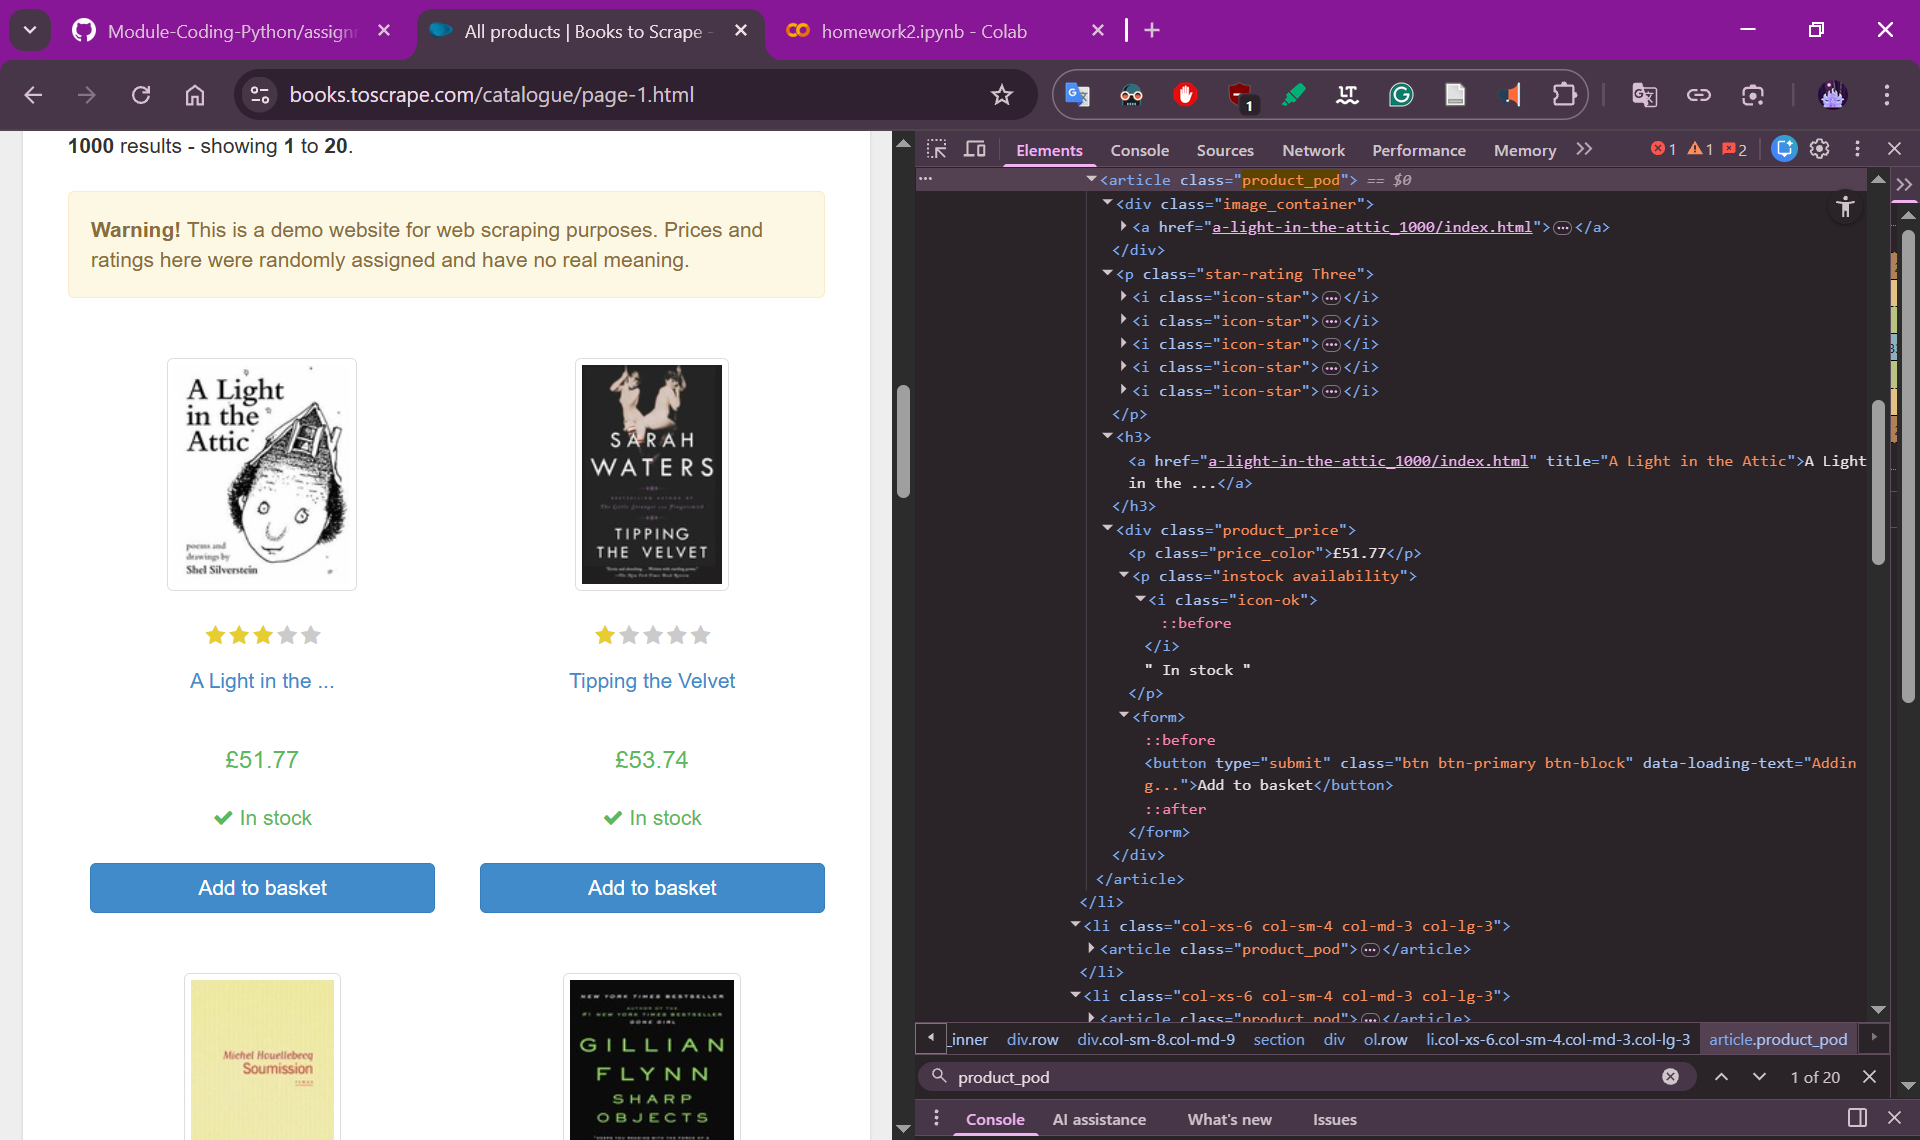

In [16]:
pip install requests beautifulsoup4

In [17]:
from typing import Optional, Dict, Any, List, Tuple
import time
import csv
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

In [18]:
# 3. Fetcher
def fetch_html(url: str, headers: Optional[Dict[str, str]] = None, timeout_s: float = 15.0) -> str:
    """
    Download a web page and return its HTML as text.
    """
    default_headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome Safari",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Language": "en-GB,en;q=0.7",
    }
    if headers:
        default_headers.update(headers)
    resp = requests.get(url, headers=default_headers, timeout=timeout_s)
    resp.raise_for_status()
    return resp.text

In [19]:
# 4. Parser
def parse_page(html: str, base_url: str) -> Tuple[List[Dict[str, Any]], Optional[str]]:
    """
    Return (items_on_this_page, next_page_absolute_url_or_None).
    Each item has at least 3 fields: title, price, rating, availability, url.
    """
    soup = BeautifulSoup(html, "html.parser")
    items: List[Dict[str, Any]] = []

    # Each book is inside <article class="product_pod">
    for card in soup.select("article.product_pod"):
        a = card.select_one("h3 a")
        title = a.get("title", "").strip() if a else ""
        rel_url = a.get("href", "").strip() if a else ""
        abs_url = urljoin(base_url, rel_url)

        price_el = card.select_one("p.price_color")
        price = price_el.get_text(strip=True) if price_el else ""

        # star rating is in p.star-rating with a class like "Three"
        rating_el = card.select_one("p.star-rating")
        rating = "Unknown"
        if rating_el:
            classes = rating_el.get("class", [])
            for word in ["One", "Two", "Three", "Four", "Five"]:
                if word in classes:
                    rating = word
                    break

        avail_el = card.select_one("p.instock.availability")
        availability = avail_el.get_text(strip=True) if avail_el else ""

        items.append({
            "title": title,
            "price": price,
            "rating": rating,
            "availability": availability,
            "url": abs_url,
        })

    # Find Next page link
    next_link = soup.select_one("li.next > a")
    next_url = urljoin(base_url, next_link.get("href")) if next_link else None
    return items, next_url

In [20]:
# 5. Pagination
def scrape_books(
    base_url: str = "https://books.toscrape.com/catalogue/",
    start_path: str = "page-1.html",
    target_min_items: int = 50,
    max_pages: int = 10,
    delay_seconds: float = 1.0
) -> List[Dict[str, Any]]:
    items_all: List[Dict[str, Any]] = []
    page_url = urljoin(base_url, start_path)
    pages_seen = 0

    while page_url and pages_seen < max_pages and len(items_all) < target_min_items:
        html = fetch_html(page_url)
        items, next_url = parse_page(html, base_url)
        items_all.extend(items)
        pages_seen += 1
        page_url = next_url
        time.sleep(delay_seconds)  # 7. Politeness

    return items_all

In [21]:
# 6. Save to CSV with ; as the separator
def export_to_csv(items: List[Dict[str, Any]], csv_path: str) -> None:
    if not items:
        print("No items to write.")
        return
    fieldnames = list(items[0].keys())  # title, price, rating, availability, url
    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames, delimiter=';')
        writer.writeheader()
        for row in items:
            # if any field is a list, join with comma
            clean = {k: (",".join(v) if isinstance(v, list) else v) for k, v in row.items()}
            writer.writerow(clean)

In [22]:
# Running everything
if __name__ == "__main__":
    BASE = "https://books.toscrape.com/catalogue/"
    START = "page-1.html"
    data = scrape_books(base_url=BASE, start_path=START, target_min_items=50, max_pages=10, delay_seconds=1.0)
    print(f"Collected {len(data)} items")
    for it in data[:3]:
        print(it)
    export_to_csv(data, "books.csv")
    print("Done. File: books.csv")

Collected 60 items
{'title': 'A Light in the Attic', 'price': 'Â£51.77', 'rating': 'Three', 'availability': 'In stock', 'url': 'https://books.toscrape.com/catalogue/a-light-in-the-attic_1000/index.html'}
{'title': 'Tipping the Velvet', 'price': 'Â£53.74', 'rating': 'One', 'availability': 'In stock', 'url': 'https://books.toscrape.com/catalogue/tipping-the-velvet_999/index.html'}
{'title': 'Soumission', 'price': 'Â£50.10', 'rating': 'One', 'availability': 'In stock', 'url': 'https://books.toscrape.com/catalogue/soumission_998/index.html'}
Done. File: books.csv


In [23]:
from typing import Optional, Dict, Any, List, Tuple
import time
import csv
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

In [24]:
# 3. Fetcher
def fetch_html(url: str, headers: Optional[Dict[str, str]] = None, timeout_s: float = 15.0) -> str:
    """
    Download a web page and return its HTML as text.
    """
    default_headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome Safari",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Language": "en-GB,en;q=0.7",
    }
    if headers:
        default_headers.update(headers)
    resp = requests.get(url, headers=default_headers, timeout=timeout_s)
    resp.raise_for_status()
    return resp.text

In [25]:
# 4. Parser
def parse_page(html: str, base_url: str) -> Tuple[List[Dict[str, Any]], Optional[str]]:
    """
    Return (items_on_this_page, next_page_absolute_url_or_None).
    Each item has at least 3 fields: title, price, rating, availability, url.
    """
    soup = BeautifulSoup(html, "html.parser")
    items: List[Dict[str, Any]] = []

    # Each book is inside <article class="product_pod">
    for card in soup.select("article.product_pod"):
        a = card.select_one("h3 a")
        title = a.get("title", "").strip() if a else ""
        rel_url = a.get("href", "").strip() if a else ""
        abs_url = urljoin(base_url, rel_url)

        price_el = card.select_one("p.price_color")
        price = price_el.get_text(strip=True) if price_el else ""

        # star rating is in p.star-rating with a class like "Three"
        rating_el = card.select_one("p.star-rating")
        rating = "Unknown"
        if rating_el:
            classes = rating_el.get("class", [])
            for word in ["One", "Two", "Three", "Four", "Five"]:
                if word in classes:
                    rating = word
                    break

        avail_el = card.select_one("p.instock.availability")
        availability = avail_el.get_text(strip=True) if avail_el else ""

        items.append({
            "title": title,
            "price": price,
            "rating": rating,
            "availability": availability,
            "url": abs_url,
        })

    # Find Next page link
    next_link = soup.select_one("li.next > a")
    next_url = urljoin(base_url, next_link.get("href")) if next_link else None
    return items, next_url

In [26]:
# 5. Pagination
def scrape_books(
    base_url: str = "https://books.toscrape.com/catalogue/",
    start_path: str = "page-1.html",
    target_min_items: int = 50,
    max_pages: int = 10,
    delay_seconds: float = 1.0
) -> List[Dict[str, Any]]:
    items_all: List[Dict[str, Any]] = []
    page_url = urljoin(base_url, start_path)
    pages_seen = 0

    while page_url and pages_seen < max_pages and len(items_all) < target_min_items:
        html = fetch_html(page_url)
        items, next_url = parse_page(html, base_url)
        items_all.extend(items)
        pages_seen += 1
        page_url = next_url
        time.sleep(delay_seconds)  # 7. Politeness

    return items_all

In [27]:
# 6. Save to CSV with ; as the separator
def export_to_csv(items: List[Dict[str, Any]], csv_path: str) -> None:
    if not items:
        print("No items to write.")
        return
    fieldnames = list(items[0].keys())  # title, price, rating, availability, url
    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames, delimiter=';')
        writer.writeheader()
        for row in items:
            # if any field is a list, join with comma
            clean = {k: (",".join(v) if isinstance(v, list) else v) for k, v in row.items()}
            writer.writerow(clean)

In [28]:
from google.colab import files

files.download('books.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# 3) Follow pages until you have at least 50 items or you hit a page limit
def scrape_books(
    base_url: str = "https://books.toscrape.com/catalogue/", # Modified base_url
    start_path: str = "page-1.html", # Modified start_path
    target_min_items: int = 50,
    max_pages: int = 10,
    delay_seconds: float = 1.0
) -> List[Dict[str, Any]]:
    items_all: List[Dict[str, Any]] = []
    page_url = urljoin(base_url, start_path)
    pages_seen = 0

    while page_url and pages_seen < max_pages and len(items_all) < target_min_items:
        html = fetch_html(page_url)
        items, next_url = parse_page(html, base_url)
        items_all.extend(items)
        pages_seen += 1
        page_url = next_url
        time.sleep(delay_seconds)  # politeness

    return items_all

In [30]:
# 5) Save to CSV with ; as the separator
def export_to_csv(items: List[Dict[str, Any]], csv_path: str) -> None:
    if not items:
        print("No items to write.")
        return
    fieldnames = list(items[0].keys())  # title, price, rating, availability, url
    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames, delimiter=';')
        writer.writeheader()
        for row in items:
            # if any field is a list, join with comma
            clean = {k: (",".join(v) if isinstance(v, list) else v) for k, v in row.items()}
            writer.writerow(clean)

8. Documentation
> Since I barely understand what I'm doing, I'm using AI to guide me a lot, so most things worked from the first try. For a reason I don't really understand (but I do a a bit) there was a problem with the URL and pagination, but Gemini fixed it. I also had a huge problem with downloading "books.csv".